In [1]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Compose
set_default_plot_size(40cm, 14cm)

home = "/home/german/labo/18/egfr/modos/"
rehome = "/home/german/labo/18/egfr/gram/"
aa = 277

277

In [2]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [3]:
function qgrammian0(mtx_1, mtx_2, weight_1 = 0)
    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    mtx_g = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
      
    if weight_1 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        weighted = diag(mtx_g) .* weight_1
        zeta = sum(weighted)
    else
        zeta = mean(diag(mtx_g))   
    end
    
    
    return zeta
end

qgrammian0 (generic function with 2 methods)

In [4]:
function qgrammian1(mtx_1, mtx_2, weight_1 = 0, weight_2 = 0)
    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    if weight_1 != 0 && weight_2 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2] || length(weight_2) != size(mtx_2)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        mtx_1 = mtx_1 * diagm(weight_1)
        mtx_2 = mtx_2 * diagm(weight_2)
    end
    
    mtx_g = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
    zeta = mean(diag(mtx_g))
    
    return zeta
end

qgrammian1 (generic function with 3 methods)

In [148]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        if i == 1
            # Include those that fall before the beggining of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
            out_counts[i] = sum(in_weight[temp_bool])
        elseif i == length(in_bins)-1
            # Include those that fall after the end of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
            out_counts[i] = sum(in_weight[temp_bool])
        else
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

# Arranco

In [643]:
# Leo nombres de structuras
tmp = readdlm(string(rehome, "/pdbs.list"))
pdbs_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));
aa = 277
aa_3 = aa * 3
aa_36 = aa_3 - 6
structs = length(pdbs_list)

# Leo activas e inactivas
tmp = readdlm(string(rehome, "/am.list"))
am_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

tmp = readdlm(string(rehome, "/im.list"))
im_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

In [644]:
# Leo nonmissing residuos de pocket
tmp = readdlm(string(rehome, "nonmis_aa_pocket"))
nonmis_aa_pocket = convert(Array{Int64, 1}, reshape(tmp, length(tmp)))

aa_pocket_nonmis = length(nonmis_aa_pocket)
aa_3_pocket_nonmis = aa_pocket_nonmis * 3

nonmis_aa_pocket_3 = Array{Int64}(aa_3_pocket_nonmis)
for i = 1:aa_pocket_nonmis
    nonmis_aa_pocket_3[3*i - 2] = nonmis_aa_pocket[i] * 3 - 2
    nonmis_aa_pocket_3[3*i - 1] = nonmis_aa_pocket[i] * 3 - 1
    nonmis_aa_pocket_3[3*i] = nonmis_aa_pocket[i] * 3
end

# Leo todos los residuos de pocket
tmp = readdlm(string(rehome, "aa_pocket"))
#tmp = readdlm(string("/home/german/labo/18/egfr/2aa_pocket"))
aa_pocket = convert(Array{Int64, 1}, reshape(tmp, length(tmp)))

aa_pocket_nonmis = length(aa_pocket)
aa_3_pocket_nonmis = aa_pocket_nonmis * 3

aa_pocket_3 = Array{Int64}(aa_3_pocket_nonmis)
for i = 1:aa_pocket_nonmis
    aa_pocket_3[3*i - 2] = aa_pocket[i] * 3 - 2
    aa_pocket_3[3*i - 1] = aa_pocket[i] * 3 - 1
    aa_pocket_3[3*i] = aa_pocket[i] * 3
end

## Versión con todos los residuos del pocket

In [538]:
am_pesos = Array{Float64, 2}(aa_36, length(am_list))

for i = 1:length(am_list)
    each = am_list[i]
    
    freq = readdlm(string(home, each, "/", "freq_", each))[8:end, 1]
    freq = convert(Array{Float64, 1}, freq)
    modos = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
    
    nsub_2 = readdlm(string(rehome, "1M14_A/", "1M14_A_", each, "_nsub"))[1:end-6, 2]
    nsub_2 = convert(Array{Int64, 1}, nsub_2)
    
    am_pesos[:, i] = [ sum(modos[aa_pocket_3, nsub_2[k]] .^ 2) / freq[nsub_2[k]] for k = 1:aa_36 ]
    am_pesos[:, i] = am_pesos[:, i] ./ sum(am_pesos[:, i]);
end

In [568]:
im_pesos = Array{Float64, 2}(aa_36, length(im_list))

for i = 1:length(im_list)
    each = im_list[i]
    
    freq = readdlm(string(home, each, "/", "freq_", each))[8:end, 1]
    freq = convert(Array{Float64, 1}, freq)
    modos = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
    
    nsub_2 = readdlm(string(rehome, "1M14_A/", "1M14_A_", each, "_nsub"))[1:end-6, 2]
    nsub_2 = convert(Array{Int64, 1}, nsub_2)
    
    im_pesos[:, i] = [ sum(modos[nonmis_aa_pocket_3, nsub_2[k]] .^ 2) / freq[nsub_2[k]] for k = 1:aa_36 ]
    im_pesos[:, i] = im_pesos[:, i] ./ sum(im_pesos[:, i]);
end

# Grafico

In [569]:
vec_im_pesos = mapslices(x -> mean(x), im_pesos[:, sortperm(im_pesos[3, :])[1:end]], 2)
vec_im_pesos = reshape(vec_im_pesos, length(vec_im_pesos))
vec_am_pesos = mapslices(x -> mean(x), am_pesos[:, sortperm(am_pesos[4, :])[1:end-2]], 2)
vec_am_pesos = reshape(vec_am_pesos, length(vec_am_pesos))

df_pesos = DataFrame(Weights = [ vec_im_pesos ./ vec_im_pesos[1] ; vec_am_pesos ./ vec_am_pesos[1]], 
    Modes = [ collect(1:aa_36) ; collect(1:aa_36) ],
    Conformer = repeat(["IM" ; "AM"], inner = [ aa_36]));

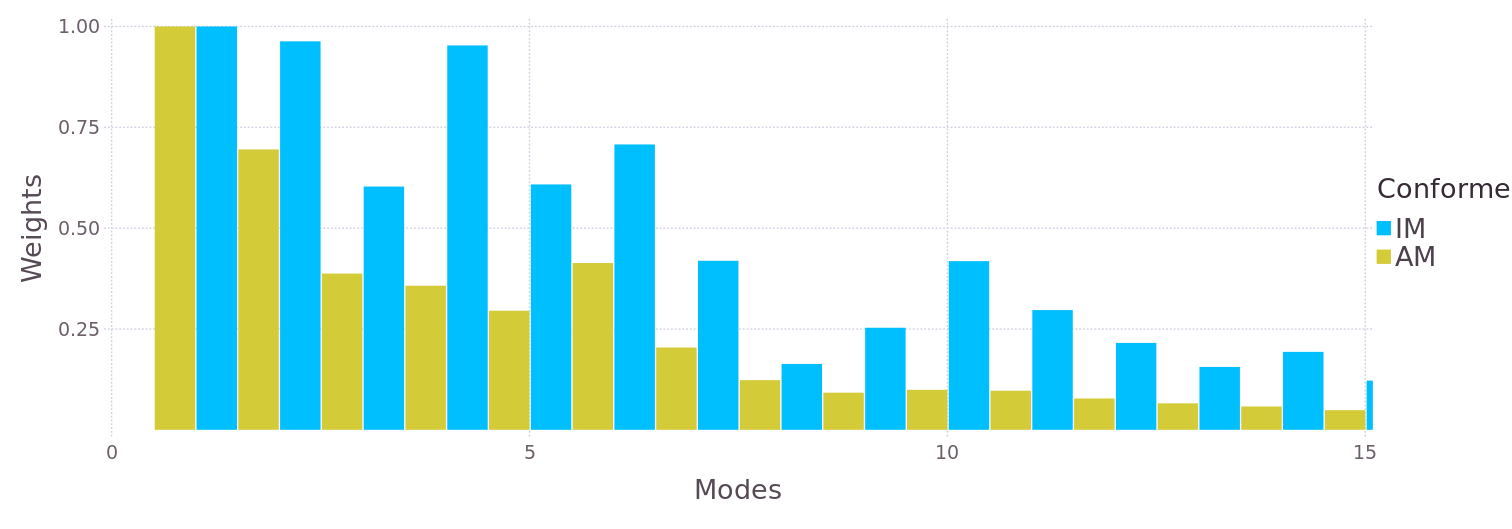

In [541]:
pdf_pesos = plot(df_pesos, x="Modes", y="Weights", color = "Conformer", Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    Coord.cartesian(xmin = 0, xmax = 15),

    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

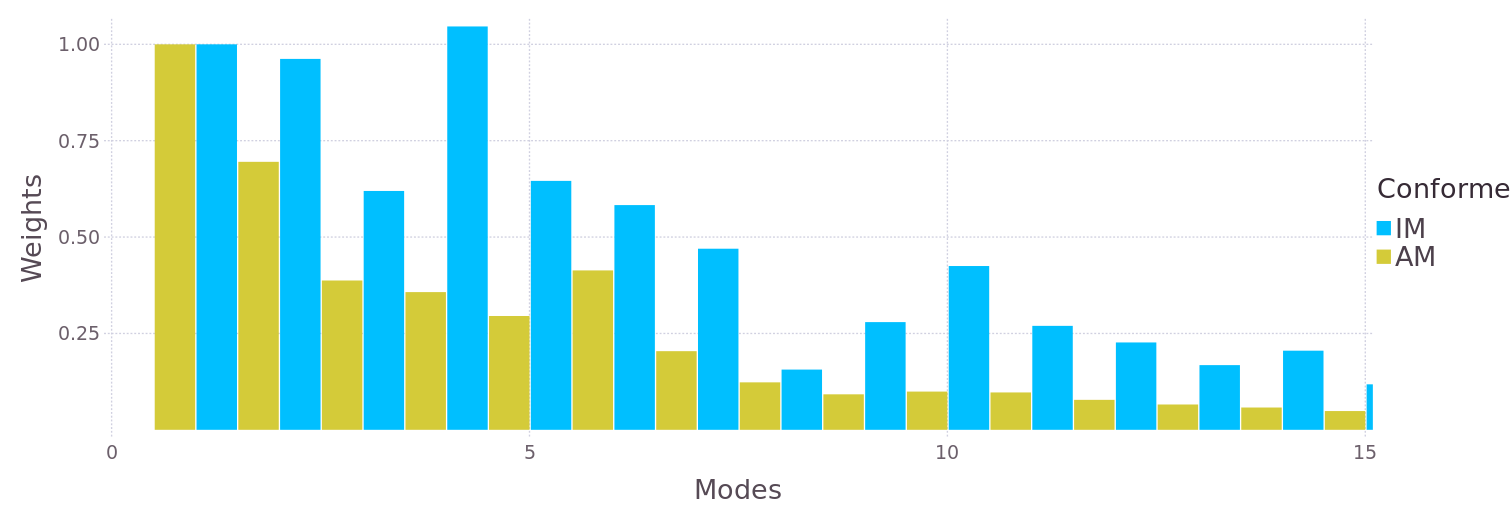

In [570]:
pdf_pesos = plot(df_pesos, x="Modes", y="Weights", color = "Conformer", Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    Coord.cartesian(xmin = 0, xmax = 15),

    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Obtengo los zeta vals

### Todos

In [542]:
am_zeta = zeros(length(am_list) - 1, length(am_list) - 1)

for i = 1:length(am_list)
    
    each = am_list[i]
    for j = i+1:length(am_list)
        
        cada = am_list[j]

        modos_1 = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
        modos_2 = readdlm(string(rehome, each, "/", each, "_", cada, "_ord"))[:, 1:aa_36]
        nsub_2 = readdlm(string(rehome, each, "/", each, "_", cada, "_nsub"))[1:end-6, 2]
        nsub_2 = convert(Array{Int64, 1}, nsub_2)
        
        am_zeta[j-1, i] = qgrammian0(modos_1, modos_2, am_pesos[nsub_2, j])
    end
    println(each)
end

1M14_A
1M17_A
2EB2_A
2GS2_A
2GS6_A
2ITN_A
2ITP_A
2ITU_A
2ITX_A
2ITZ_A
3IKA_A
3UG1_A
3VJN_A
3W2O_A
4G5J_A
4I23_A
4LI5_A
4LQM_A
4R3P_A
4R5S_A
4RJ4_A
4ZAU_A
5C8K_A
5CAO_A
5CAP_A
5CAV_A
5CZH_A
5EM5_A
5EM6_A
5EM7_A
5EM8_A
5HIC_A


In [571]:
im_zeta = zeros(length(im_list) - 1, length(im_list) - 1)

for i = 1:length(im_list)
    each = im_list[i]
    for j = i+1:length(im_list)
        cada = im_list[j]

        modos_1 = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
        modos_2 = readdlm(string(rehome, each, "/", each, "_", cada, "_ord"))[:, 1:aa_36]
        nsub_2 = readdlm(string(rehome, each, "/", each, "_", cada, "_nsub"))[1:end-6, 2]
        nsub_2 = convert(Array{Int64, 1}, nsub_2)

        im_zeta[j-1, i] = qgrammian0(modos_1, modos_2, im_pesos[nsub_2, j])
    end
    println(each)
end

1XKK_A
2GS7_A
2RGP_A
3BEL_A
3GT8_A
3IKA_B
3LZB_A
3W2R_A
3W2S_A
3W32_A
4ZJV_A
5CNN_A


# Grafico

In [572]:
tmp = reshape(im_zeta, length(im_zeta))
vec_im_zeta = tmp[tmp .!= 0.0];

tmp = reshape(am_zeta, length(am_zeta))
vec_am_zeta = tmp[tmp .!= 0.0];

In [573]:
hbins = collect(minimum(vec_am_zeta)+.003:0.0003:maximum(vec_am_zeta))
hweights_im = repeat([1.0], inner = [length(vec_im_zeta)])
hweights_am = repeat([1.0], inner = [length(vec_am_zeta)])

counts_im, bins_im = WeightedHist(vec_im_zeta, hbins, hweights_im, true)
df_hist_im = DataFrame(Probability = counts_im, Zeta = bins_im)

counts_am, bins_am = WeightedHist(vec_am_zeta, hbins, hweights_am, true);
df_hist_am = DataFrame(Probability = counts_am, Zeta = bins_am);

df_hist = DataFrame(Probability = [ counts_im ; counts_am ],
    Zeta = [ bins_im ; bins_am ],
    Conformer = repeat(["IM" ; "AM"], inner = [ length(bins_im)]));

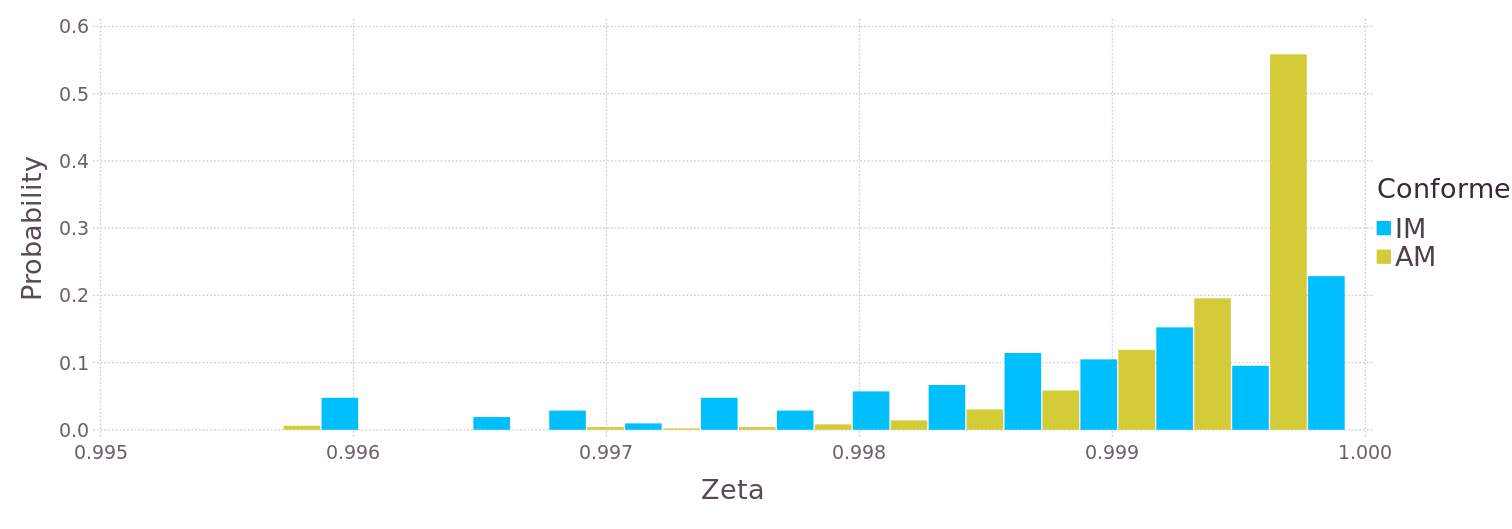

In [555]:
pdf_mode_κ_whole_Whis = plot(df_hist, x="Zeta", y="Probability", color = "Conformer",
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.7),

    Theme(bar_spacing=2pt, grid_line_width=1pt, key_label_font_size = 20pt,
    minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

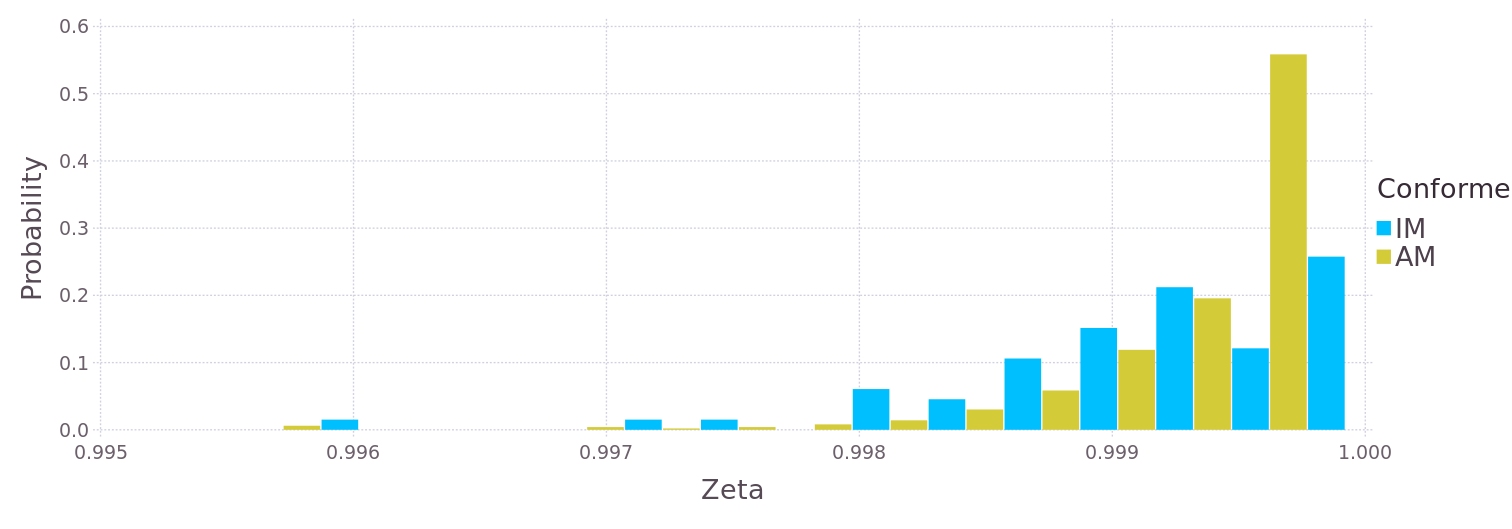

In [574]:
pdf_mode_κ_whole_Whis = plot(df_hist, x="Zeta", y="Probability", color = "Conformer",
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.7),

    Theme(bar_spacing=2pt, grid_line_width=1pt, key_label_font_size = 20pt,
    minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

In [556]:
tmp = mapslices(x -> sum(x), (im_zeta + transpose(im_zeta) - diagm(diag(im_zeta))) .< 0.999, 2)
tmp = reshape(tmp, length(tmp))

14-element Array{Int64,1}:
  4
  4
  5
  8
 10
  9
  8
  8
  8
  5
  3
 13
 10
  5

In [560]:
sortperm(tmp, rev = true)

14-element Array{Int64,1}:
 12
  5
 13
  6
  4
  7
  8
  9
  3
 10
 14
  1
  2
 11

In [562]:
im_list[sortperm(tmp, rev = true)]

14-element Array{String,1}:
 "3W33_A"
 "3GOP_A"
 "4I1Z_A"
 "3GT8_A"
 "3BEL_A"
 "3IKA_B"
 "3LZB_A"
 "3W2R_A"
 "2RGP_A"
 "3W2S_A"
 "4ZJV_A"
 "1XKK_A"
 "2GS7_A"
 "3W32_A"

In [575]:
biam_zeta = zeros(length(am_list) - 1, length(am_list) - 1)

for i = 1:length(am_list)
    each = am_list[i]
    for j = i+1:length(am_list)
        cada = am_list[j]

        modos_1 = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
        modos_2 = readdlm(string(rehome, each, "/", each, "_", cada, "_ord"))[:, 1:aa_36]
        nsub_2 = readdlm(string(rehome, each, "/", each, "_", cada, "_nsub"))[1:end-6, 2]
        nsub_2 = convert(Array{Int64, 1}, nsub_2)
        
        biam_zeta[j-1, i] = qgrammian1(modos_1, modos_2, am_pesos[:, i], am_pesos[nsub_2, j])
    end
    println(each)
end

1M14_A
1M17_A
2EB2_A
2GS2_A
2GS6_A
2ITN_A
2ITP_A
2ITU_A
2ITX_A
2ITZ_A
3IKA_A
3UG1_A
3VJN_A
3W2O_A
4G5J_A
4I23_A
4LI5_A
4LQM_A
4R3P_A
4R5S_A
4RJ4_A
4ZAU_A
5C8K_A
5CAO_A
5CAP_A
5CAV_A
5CZH_A
5EM5_A
5EM6_A
5EM7_A
5EM8_A
5HIC_A


In [576]:
biim_zeta = zeros(length(im_list) - 1, length(im_list) - 1)

for i = 1:length(im_list)
    each = im_list[i]
    for j = i+1:length(im_list)
        cada = im_list[j]

        modos_1 = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
        modos_2 = readdlm(string(rehome, each, "/", each, "_", cada, "_ord"))[:, 1:aa_36]
        nsub_2 = readdlm(string(rehome, each, "/", each, "_", cada, "_nsub"))[1:end-6, 2]
        nsub_2 = convert(Array{Int64, 1}, nsub_2)

        biim_zeta[j-1, i] = qgrammian1(modos_1, modos_2, am_pesos[:, i], im_pesos[nsub_2, j])
    end
    println(each)
end

1XKK_A
2GS7_A
2RGP_A
3BEL_A
3GT8_A
3IKA_B
3LZB_A
3W2R_A
3W2S_A
3W32_A
4ZJV_A
5CNN_A


In [577]:
tmp = reshape(biim_zeta, length(biim_zeta))
vec_im_zeta = tmp[tmp .!= 0.0];

tmp = reshape(biam_zeta, length(biam_zeta))
vec_am_zeta = tmp[tmp .!= 0.0];

In [584]:
hbins = collect(minimum(vec_im_zeta):1e-7:maximum(vec_im_zeta) - 5e-6)
hweights_im = repeat([1.0], inner = [length(vec_im_zeta)])
hweights_am = repeat([1.0], inner = [length(vec_am_zeta)])

counts_im, bins_im = WeightedHist(vec_im_zeta, hbins, hweights_im, true)
df_hist_im = DataFrame(Probability = counts_im, Zeta = bins_im)

counts_am, bins_am = WeightedHist(vec_am_zeta, hbins, hweights_am, true);
df_hist_am = DataFrame(Probability = counts_am, Zeta = bins_am);

df_hist = DataFrame(Probability = [ counts_im ; counts_am ],
    Zeta = [ bins_im ; bins_am ],
    Conformer = repeat(["IM" ; "AM"], inner = [ length(bins_im)]));

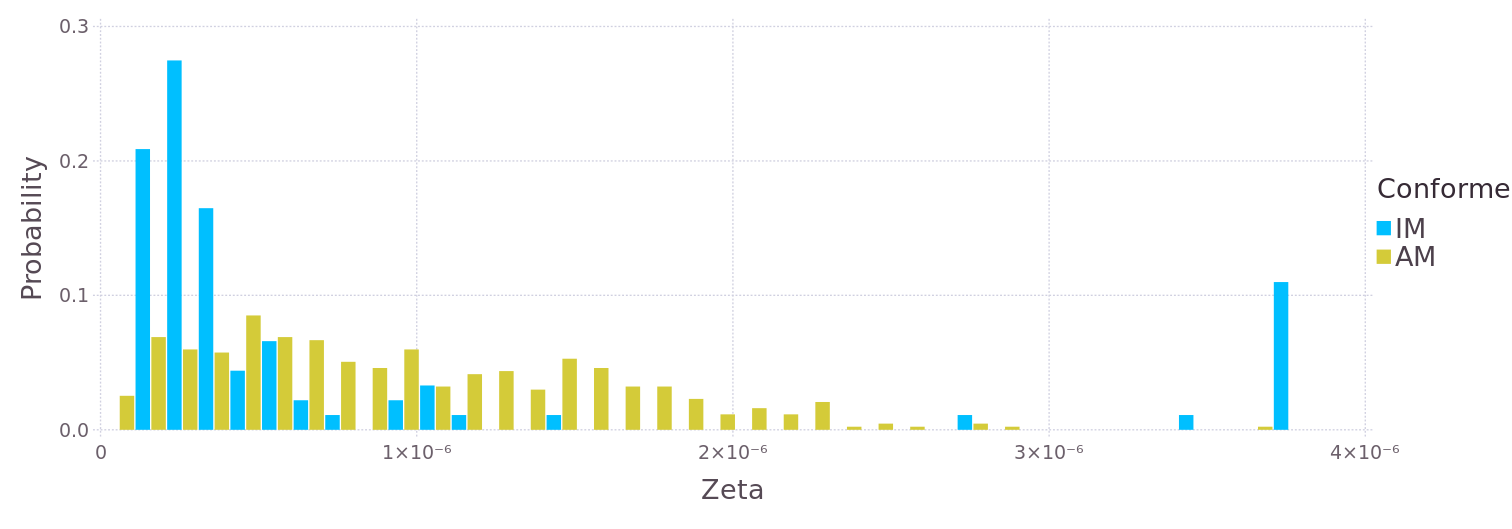

In [330]:
pdf_mode_κ_whole_Whis = plot(df_hist, x="Zeta", y="Probability", color = "Conformer",
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.7),

    Theme(bar_spacing=2pt, grid_line_width=1pt, key_label_font_size = 20pt,
    minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

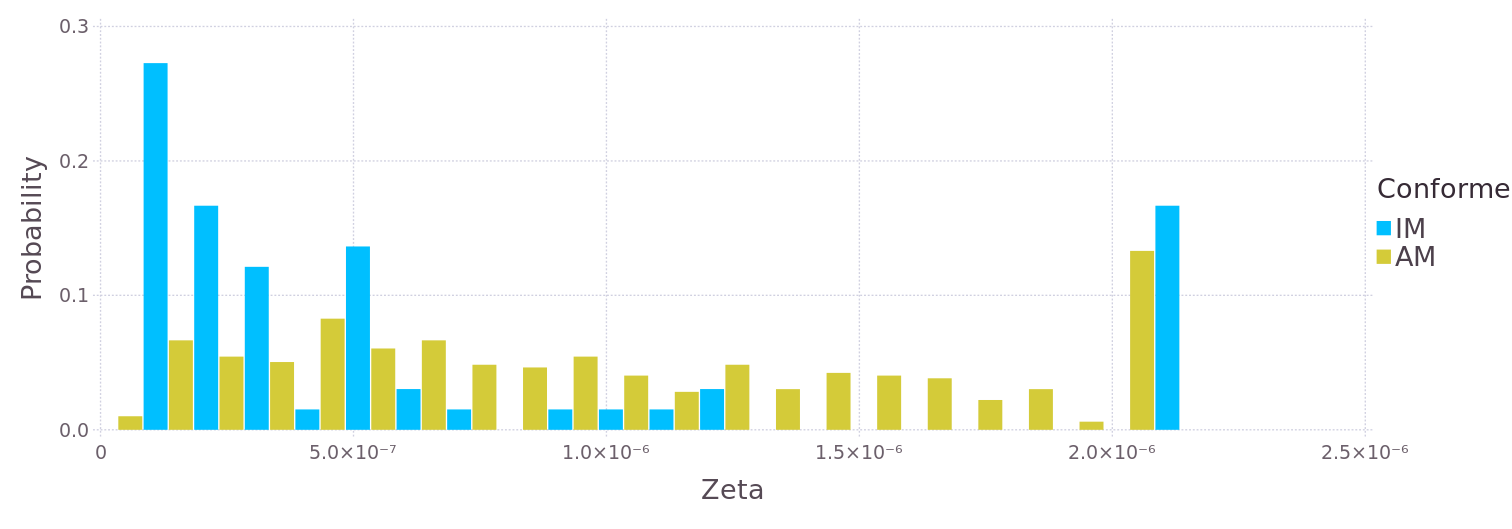

In [585]:
pdf_mode_κ_whole_Whis = plot(df_hist, x="Zeta", y="Probability", color = "Conformer",
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.7),

    Theme(bar_spacing=2pt, grid_line_width=1pt, key_label_font_size = 20pt,
    minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

In [ ]:
writedlm(string(rehome, "am_zeta"), am_zeta)
writedlm(string(rehome, "im_zeta"), im_zeta)

In [683]:
im_zeta = convert(Array{Float64, 2}, readdlm(string(rehome, "zeta_im"))[2:end, :])
am_zeta = convert(Array{Float64, 2}, readdlm(string(rehome, "zeta_am"))[2:end, :]);

im_nd = convert(Array{Float64, 2}, readdlm(string(rehome, "nd_im"))[2:end, :])
am_nd = convert(Array{Float64, 2}, readdlm(string(rehome, "nd_am"))[2:end, :]);

In [684]:
tmp = reshape(im_zeta, length(im_zeta))
vec_im_zeta = tmp[tmp .!= 0.0];

tmp = reshape(am_zeta, length(am_zeta))
vec_am_zeta = tmp[tmp .!= 0.0];;

tmp = reshape(im_nd, length(im_nd))
vec_im_nd = tmp[tmp .!= 0.0];

tmp = reshape(am_nd, length(am_nd))
vec_am_nd = tmp[tmp .!= 0.0];;

In [680]:
hbins = collect(minimum(vec_am_zeta):2e-6:maximum(vec_am_zeta) - 5e-5)
hweights_im = repeat([1.0], inner = [length(vec_im_zeta)])
hweights_am = repeat([1.0], inner = [length(vec_am_zeta)])

counts_im, bins_im = WeightedHist(vec_im_zeta, hbins, hweights_im, true)
df_hist_im = DataFrame(Probability = counts_im, Zeta = bins_im)

counts_am, bins_am = WeightedHist(vec_am_zeta, hbins, hweights_am, true);
df_hist_am = DataFrame(Probability = counts_am, Zeta = bins_am);

df_zeta_hist = DataFrame(Probability = [ counts_im ; counts_am ],
    Zeta = [ bins_im ; bins_am ],
    Conformer = repeat(["IM" ; "AM"], inner = [ length(bins_im)]));

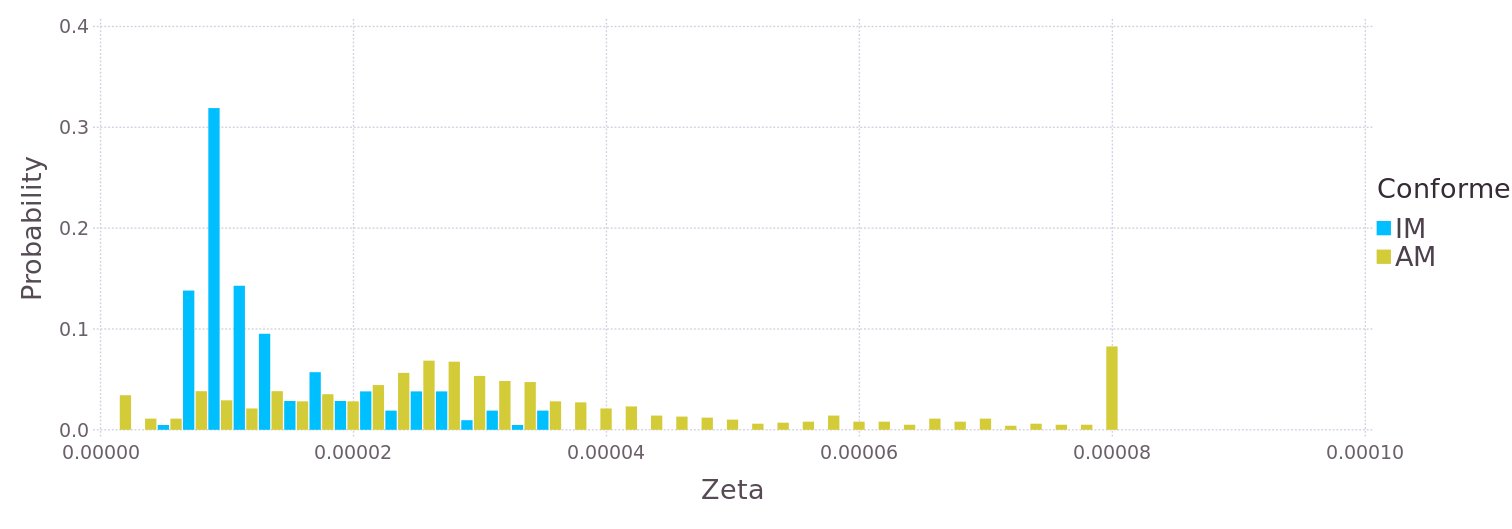

In [681]:
pdf_mode_κ_whole_Whis = plot(df_zeta_hist, x="Zeta", y="Probability", color = "Conformer",
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.7),

    Theme(bar_spacing=2pt, grid_line_width=1pt, key_label_font_size = 20pt,
    minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

In [690]:
hbins = collect(minimum(vec_am_nd):2e-1:maximum(vec_am_nd) - 5e-5)
hweights_im = repeat([1.0], inner = [length(vec_im_nd)])
hweights_am = repeat([1.0], inner = [length(vec_am_nd)])

counts_im, bins_im = WeightedHist(vec_im_nd, hbins, hweights_im, true)
df_hist_im = DataFrame(Probability = counts_im, nd = bins_im)

counts_am, bins_am = WeightedHist(vec_am_nd, hbins, hweights_am, true);
df_hist_am = DataFrame(Probability = counts_am, nd = bins_am);

df_nd_hist = DataFrame(Probability = [ counts_im ; counts_am ],
    ND = [ bins_im ; bins_am ],
    Conformer = repeat(["IM" ; "AM"], inner = [ length(bins_im)]));

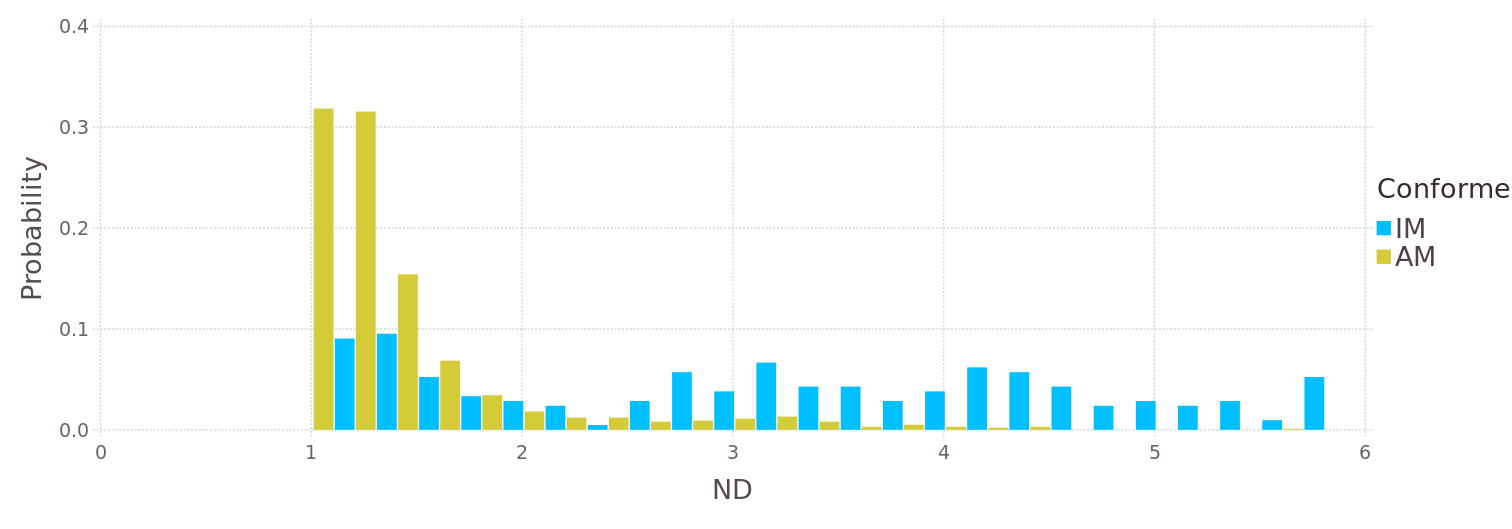

In [691]:
pdf_mode_κ_whole_Whis = plot(df_nd_hist, x="ND", y="Probability", color = "Conformer",
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.7),

    Theme(bar_spacing=2pt, grid_line_width=1pt, key_label_font_size = 20pt,
    minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

In [695]:
tmp = mapslices(x -> sum(x), im_nd, 2)
tmp = reshape(tmp, length(tmp))
sortperm(tmp)

14-element Array{Int64,1}:
  8
  1
  6
  5
  7
 11
  4
  3
  9
 10
 13
 14
  2
 12

In [697]:
im_list[sortperm(tmp)]

14-element Array{String,1}:
 "3LZB_A"
 "1XKK_A"
 "3GT8_A"
 "3GOP_A"
 "3IKA_B"
 "3W32_A"
 "3BEL_A"
 "2RGP_A"
 "3W2R_A"
 "3W2S_A"
 "4I1Z_A"
 "4ZJV_A"
 "2GS7_A"
 "3W33_A"

In [698]:
tmp = mapslices(x -> sum(x), am_zeta, 2)
tmp = reshape(tmp, length(tmp))
sortperm(tmp)

31-element Array{Int64,1}:
 29
 28
 14
 31
 13
  9
 27
 24
 21
 18
  1
 19
  5
  ⋮
 30
  3
 20
  2
  7
 26
 22
 15
 16
 12
 11
  4

In [699]:
am_list[sortperm(tmp)]

31-element Array{String,1}:
 "5EM6_A"
 "5EM5_A"
 "3W2O_A"
 "5EM8_A"
 "3VJN_A"
 "2ITX_A"
 "5CZH_A"
 "5CAO_A"
 "4RJ4_A"
 "4LQM_A"
 "1M14_A"
 "4R3P_A"
 "2GS6_A"
 ⋮       
 "5EM7_A"
 "2EB2_A"
 "4R5S_A"
 "1M17_A"
 "2ITP_A"
 "5CAV_A"
 "4ZAU_A"
 "4G5J_A"
 "4I23_A"
 "3UG1_A"
 "3IKA_A"
 "2GS2_A"